In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

/home/codespace/anaconda3/envs/experiment-tracking/lib/python3.12/site-packages/mlflow/store/dbmodels/models.py:13: MovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [2]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df['duration'] >=1) & (df['duration'] <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [3]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')

df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet')

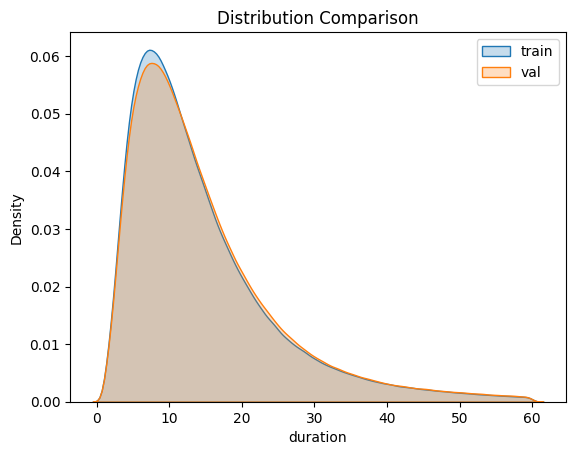

In [4]:
sns.kdeplot(df_train.duration, label="train", fill=True)
sns.kdeplot(df_val.duration, label="val", fill=True)

plt.legend()
plt.title('Distribution Comparison')
plt.show()

In [5]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [6]:
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.fit_transform(val_dicts)

In [7]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

ValueError: X has 24150 features, but LinearRegression is expecting 24016 features as input.

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5797812 stored elements and shape (2898906, 24016)>